In [118]:
begin
	using Flux
	using Flux: onehot
	using Flux: gradient
	using Flux.Optimise: update!
	using Flux: onecold
	using CUDA
	using Transformers
	using Transformers.Basic 
    using Transformers.Datasets: batched
    enable_gpu(false) 
	using Flux: @functor
	using ..Transformers: Abstract3DTensor, Container, epsilon, batchedmul, batched_triu!
	using Plots
end
	

In [119]:
#Labeling: vielleicht ändern

begin
	labels = map(string, 1:10)
	startsym = "11"
	endsym = "12"
	unksym = "0"
	labels = [unksym, startsym, endsym, labels...]
	vocab = Vocabulary(labels, unksym)
end

Vocabulary{String}(13, unk=0)

In [120]:
#function for generate training datas 

#nichts ändern
sample_data() = (d = map(string, rand(1:10, 10)); (d,d))

sample_data (generic function with 1 method)

In [121]:
#nichts ändern

sample_data()

(["8", "6", "10", "10", "3", "8", "4", "4", "7", "5"], ["8", "6", "10", "10", "3", "8", "4", "4", "7", "5"])

In [122]:
#function for adding start & end symbol

#nichts ändern
preprocess(x) = [startsym, x..., endsym]

preprocess (generic function with 1 method)

In [123]:
#nichts ändern

begin
    @show sample_ex = preprocess.(sample_data())
    @show encoded_sample_ex = vocab(sample_ex[1]) #use Vocabulary to encode the training data
    end

12-element Vector{Int64}:
  2
 10
 12
  8
  5
  5
 11
  5
 12
  5
  4
  3

In [124]:
#nichts ändern
sample = preprocess.(sample_data())

(["11", "1", "1", "2", "6", "10", "3", "10", "1", "2", "7", "12"], ["11", "1", "1", "2", "6", "10", "3", "10", "1", "2", "7", "12"])

In [125]:
#nichts ändern
encoded_sample = vocab(sample[1])

12-element Vector{Int64}:
  2
  4
  4
  5
  9
 13
  6
 13
  4
  5
 10
  3

In [126]:
#define a Word embedding layer which turn word index to word vector

#embeding vielleicht ändern
embed = Embed(128, length(vocab)) |> gpu

Embed(128)

In [127]:
#define a position embedding layer metioned above

#embeding vielleicht ändern
pe = PositionEmbedding(128) |> gpu

PositionEmbedding(128)

In [128]:
#wrapper for get embedding

#embeding vielleicht ändern
function embedding(x)
    we = embed(x, inv(sqrt(128)))
    e = we .+ pe(we)
    return e
  end

embedding (generic function with 1 method)

In [129]:
abstract type AbstractAttention end

In [130]:
create_atten_mask1(T::Type, score::AbstractArray, ::Nothing, future) = create_atten_mask1(T, score, fill!(similar(score, size(score,1), size(score, 2), 1), one(T)), future)
function create_atten_mask1(T::Type, score::AbstractArray, _mask::AbstractArray, future::Bool=false)
  #size(mask) == (q, k, n, b)

  # ql, kl = size(mask)
  mask = copy(_mask)

  maskval = convert(T, -1e9)
  !future && batched_triu!(mask, 0)
  mask .= (1 .- mask) .* maskval
  return mask
end

create_atten_mask1 (generic function with 3 methods)

In [131]:
Flux.@nograd create_atten_mask1

In [132]:
struct MultiheadAttention_1{Q<:Dense, K<:Dense, V<:Dense, O<:Dense, DP<:Dropout} <: AbstractAttention
    head::Int
    future::Bool
    iqproj::Q
    ikproj::K
    ivproj::V
    oproj::O
    drop::DP
end

In [133]:
Flux.functor(mh::MultiheadAttention_1) = (mh.iqproj, mh.ikproj, mh.ivproj, mh.oproj), m -> MultiheadAttention_1(mh.head, mh.future, m..., mh.drop)


In [134]:
"""
    MultiheadAttention(head::Int, is::Int, hs::Int, os::Int;
                       future::Bool=true, pdrop = 0.1)
Multihead dot product Attention Layer, `head` is the number of head, 
`is` is the input size, `hs` is the hidden size of input projection layer of each head, 
`os` is the output size. When `future` is `false`, the k-th token can't see tokens at > k. 
`pdrop` is the dropout rate.
"""

"    MultiheadAttention(head::Int, is::Int, hs::Int, os::Int;\n                       future::Bool=true, pdrop = 0.1)\nMultihead dot product Attention Layer, `head` is the number of head, \n`is` is the input size, `hs` is the hidden size of input projection layer of each head, \n`os` is the output size. When `future` is `false`, the k-th token can't see tokens at > k. \n`pdrop` is the dropout rate.\n"

In [135]:
MultiheadAttention_1(head::Int,
                   is::Int,
                   hs::Int,
                   os::Int;
                   future::Bool=true, pdrop = 0.1) = MultiheadAttention_1(head,
                                                                        future,
                                                                        Dense(is, hs*head),
                                                                        Dense(is, hs*head),
                                                                        Dense(is, hs*head),
                                                                        Dense(hs*head, os),
                                                                        Dropout(pdrop),
                                                                        )


function Base.show(io::IO, mh::MultiheadAttention_1)
    hs = div(size(mh.iqproj.weight)[1], mh.head)
    is = size(mh.iqproj.weight)[end]
    os = size(mh.oproj.weight)[1]

    print(io, "MultiheadAttention(")
    print(io, "head=$(mh.head), ")
    print(io, "head_size=$(hs), ")
    print(io, "$(is)=>$(os)")

    if Flux.istraining()
        print(io, ", dropout=$(mh.drop.p))")
    else
        print(io, ")")
    end
end

In [136]:
function (mh::MultiheadAttention_1)(query::A1,
    key::A2,
    value::A3;
    mask=nothing) where {T,
                         A1 <: Abstract3DTensor{T},
                         A2 <: Abstract3DTensor{T},
                         A3 <: Abstract3DTensor{T}}
qs = size(query)
ks = size(key)
vs = size(value)

#size(ipq) == (h, q_seq_len, batch)
ipq = @toNd mh.iqproj(query)
ipk = @toNd mh.ikproj(key)
ipv = @toNd mh.ivproj(value)
@show(ipq)

h = size(ipq, 1)
hs = div(h, mh.head)

#size(ipq) == (hs, q_seq_len, head, batch)
ipq = permutedims(reshape(ipq, hs, mh.head, qs[2], qs[3]), [1, 3, 2, 4])
ipk = permutedims(reshape(ipk, hs, mh.head, ks[2], ks[3]), [1, 3, 2, 4])
ipv = permutedims(reshape(ipv, hs, mh.head, vs[2], vs[3]), [1, 3, 2, 4])

#size(ipq) == (hs, q_seq_len, head * batch)
ipq = reshape(ipq, hs, qs[2], :)
ipk = reshape(ipk, hs, ks[2], :)
ipv = reshape(ipv, hs, vs[2], :)

atten = attention1(ipq,ipk,ipv,
mask,
mh.future,
mh.drop)

atten = permutedims(reshape(atten, hs, qs[2], mh.head, qs[3]), [1, 3, 2, 4]) #size(atten) == (hs, head, ql, b)
atten = reshape(atten, h, qs[2], qs[3]) #size(atten) == (h, ql, b)

out = @toNd mh.oproj(atten)
out #size(out) == (h, q_seq_len, batch)
end

function (mh::MultiheadAttention_1)(query::A1,
    key::A2,
    value::A3;
    mask=nothing) where {T,
                         A1 <: AbstractMatrix{T},
                         A2 <: AbstractMatrix{T},
                         A3 <: AbstractMatrix{T}}

# size(query) == (dims, seq_len)
ipq = mh.iqproj(query)
ipk = mh.ikproj(key)
ipv = mh.ivproj(value)

h = size(ipq)[1] #h == hs * head
hs = div(h, mh.head)

#size(hq) == (hs, seq_len, head)
hq = permutedims(reshape(ipq, hs, mh.head, :), [1, 3, 2])
hk = permutedims(reshape(ipk, hs, mh.head, :), [1, 3, 2])
hv = permutedims(reshape(ipv, hs, mh.head, :), [1, 3, 2])

atten = attention1(hq, hk, hv,
mask,
mh.future,
mh.drop)

# size(atten) == (head*hs, seq_len)
atten = reshape(permutedims(atten, [1, 3, 2]), h, :)

mh.oproj(atten)
end



In [137]:
function CausalLinearAttention(queryDimensions)
    feature_map = nelu(queryDimensions)

end

CausalLinearAttention (generic function with 1 method)

In [138]:
function make_sizes_compatible(Q, K)
    N, L, H, E = Q.shape
    _, S, _, _ = K.shape
        if L == S
            return Q, K
        end
        if L < S
            return Q, K[:, :L, :, :]
        end
        if L > S
            return Q, torch.cat([K, K.new_zeros(N, L-S, H, E)], dim=1)
        end
end

make_sizes_compatible (generic function with 1 method)

In [139]:
function forward(queries, keys, values, attn_mask, query_lengths, key_lengths)
    Q = nelu(queries)
    K = nelu(keys)
    K = K * key_lengths.float_matrix[:, :, None, None]

    Q, K = make_sizes_compatible(Q, K)

    Z = 1/(torch.einsum("nlhi,nlhi->nlh", Q, K.cumsum(1)) + self.eps)  # diese Funktionen und Packages gehen nur mit Torch und CUDA GPU!!

    # Compute the unnormalized result
    V = causal_linear(
        Q,
        K,
        values
    )

    return V * Z[:, :, :, None]
end

forward (generic function with 1 method)

In [140]:
function apply_mask1(score, mask)
    s = size(score)
    ms = size(mask)
    bxn = s[end]
    b = ms[end]
    if bxn == b || b == 1
      return score .+ mask
    else
      return reshape(reshape(score, s[1:end-1]..., :, b) .+
                     reshape(mask, ms[1:end-1]..., 1, b), s)
    end
  end
  
  apply_mask1(score::AbstractArray{T}, ::Nothing, future) where T = future ? score : apply_mask1(score, create_atten_mask1(T, score, nothing, future))
  apply_mask1(score::AbstractArray{T}, mask, future) where T = apply_mask(score, create_atten_mask1(T, score, mask, future))
  

apply_mask1 (generic function with 3 methods)

In [141]:
#hier anstatt softmax linear
function attention1(query::A1,
    key::A2,
    value::A3,
    mask, future::Bool,
    dropout) where {T,
                    A1 <: Abstract3DTensor{T},
                    A2 <: Abstract3DTensor{T},
                    A3 <: Abstract3DTensor{T}}
#size(query) == (dims, {q,k}_seq_len, batch) == size(key) == size(value)
#size(ipq) == (hs, q_seq_len, head * batch)
#size(score) == (k_seq_len, q_seq_len, batch)

dk = size(key, 1)
score = batchedmul(key, query; transA = true) 
score = score ./ convert(T, sqrt(dk))

# score = apply_mask1(score, mask, future)
score = softmax(score; dims=1)
dropout !== nothing && (score = dropout(score))
batchedmul(value, score) #size(return) == (dims, q_seq_len, batch)

#size(query) == (batch, {q,k}_seq_len, dims) == size(key) == size(value)
#=
query = permutedims(query,(3,2,1))
key = permutedims(key,(3,2,1))
value = permutedims(value,(3,2,1))

qs = size(query)
ks = size(key)
vs = size(value)

#depth = div(mh.size, mh.head)
depth = div(512, 8)   

#query = nelu(splitHeads(query, qs[1], mh.head, depth))
#key = nelu(splitHeads(key, qs[1], mh.head, depth))
#value = splitHeads(value, qs[1], mh.head, depth)

query = nelu(splitHeads(query, qs[1], 8, depth))
key = nelu(splitHeads(key, ks[1], 8, depth))
value = splitHeads(value, vs[1], 8, depth)
# size(k_v) == (batch_size, depth_k, depth_v, seq_len_v)
@einsum k_v[m,d,e,h] := key[m,j,h,d]*value[m,j,h,e]

k_reduced = sum(key, dims=2) .+ 1e-8

@einsum z_1[m,l,h] := query[m,l,h,d]*k_reduced[m,h,d]
# size(z) == (batch_size, num_heads, seq_len_q)
z = 1/z_1 # ...
# size(output) == (batch_size,len_q, heads, depth_v)
@einsum output[m,l,h,e] := query[m,l,h,d]*k_v[m,d,e,h]*z[m,l,h]

#output = reshape(output, (qs[1], qs[2], mh.head*depth))
# size(output) == (batch_size,len_q, d_model)
output = reshape(output, (qs[1], :, 8*depth))

output = permutedims(output,(3,2,1))
#(dims, q_seq_len, batch)
=#
end

attention1 (generic function with 1 method)

In [142]:
function attention(query::A1,
    key::A2,
    value::A3,
    mask, future::Bool,
    dropout) where {T,
                    A1 <: Abstract3DTensor{T},
                    A2 <: Abstract3DTensor{T},
                    A3 <: Abstract3DTensor{T}}
#size(query) == (dims, {q,k}_seq_len, batch) == size(key) == size(value)
#size(score) == (k_seq_len, q_seq_len, batch)
dk = size(key, 1)
score = batchedmul(key, query; transA = true)
score = score ./ convert(T, sqrt(dk))

score = apply_mask1(score, mask, future)
score = softmax(score; dims=1)
dropout !== nothing && (score = dropout(score))
batchedmul(value, score) #size(return) == (dims, q_seq_len, batch)
end

attention (generic function with 1 method)

In [143]:
function causal_linear(query, key, value)
    query = query.permute(0,2,1,3).contiguous()
    key = key.permute(0,2,1,3).contiguous()
    value = value.permute(0,2,1,3).contiguous()
    value_new = causal_dot_product(Q, K, V)
    return value_new.permute(0,2,1,3).contiguous()
end

causal_linear (generic function with 1 method)

In [145]:
abstract type AbstractTransformer end

In [146]:
oftf(x, y) = oftype(float(x), y)


nelu(x, α=1) = ifelse(x ≥ 0, float(x)+1, @fastmath oftf(x, α) * (exp(x) - 1)+1)

nelu (generic function with 2 methods)

In [147]:
struct PwFFN{Di<:Dense, Do<:Dense}
    din::Di
    dout::Do
end

@functor PwFFN


"just a wrapper for two dense layer."
PwFFN(size::Int, h::Int, act = elu) = PwFFN(  #relu vielleicht auf elu + 1 oder nur elu ändern
    Dense(size, h, act),
    Dense(h, size)
)

function (pw::PwFFN)(x::AbstractMatrix)
  # size(x) == (dims, seq_len)
  pw.dout(pw.din(x))
end

function (pw::PwFFN)(x::A) where {T, N, A<:AbstractArray{T, N}}
  new_x = reshape(x, size(x, 1), :)
  y = pw(new_x)
  return reshape(y, Base.setindex(size(x), size(y, 1), 1))
end

In [148]:
struct Transformer1{MA<:MultiheadAttention_1, LA<:LayerNorm, P<:PwFFN, LP<:LayerNorm, DP<:Dropout} <: AbstractTransformer
    mh::MA
    mhn::LA
    pw::P
    pwn::LP
    drop::DP
end

@functor Transformer1


"""
    Transformer(size::Int, head::Int, ps::Int;
                future::Bool = true, act = relu, pdrop = 0.1)
    Transformer(size::Int, head::Int, hs::Int, ps::Int;
                future::Bool = true, act = relu, pdrop = 0.1)  

Transformer layer.

`size` is the input size. if `hs` is not specify, use `div(size, head)` as the hidden size of multi-head attention. 
`ps` is the hidden size & `act` is the activation function of the positionwise feedforward layer. 
When `future` is `false`, the k-th token can't see the j-th tokens where j > k. `pdrop` is the dropout rate.
"""

########
#ganze Funktion von Transformer ändern
########
function Transformer1(size::Int, head::Int, ps::Int; future::Bool = true, act = elu, pdrop = 0.1)  #relu vielleicht wieder auf elu ändern
    rem(size, head) != 0 && error("size not divisible by head")
    Transformer1(size, head, div(size, head), ps;future=future, act=act, pdrop=pdrop)
end

Transformer1(size::Int, head::Int, hs::Int, ps::Int; future::Bool = true, act = elu, pdrop = 0.1) = Transformer1(
    MultiheadAttention_1(head, size, hs, size; future=future, pdrop=pdrop),
    LayerNorm(size),
    PwFFN(size, ps, act),
    LayerNorm(size),
    Dropout(pdrop),     #braucht man das? vielleicht nicht
)

function (t::Transformer1)(x::A, mask=nothing) where {T, N, A<:AbstractArray{T, N}}
    dropout = t.drop
    a = t.mh(x, x, x; mask=mask)
    a = dropout(a)
    res_a = x + a
    res_a = t.mhn(res_a)
    pwffn = t.pw(res_a)
    pwffn = dropout(pwffn)
    res_pwffn = res_a + pwffn
    res_pwffn = t.pwn(res_pwffn)
    res_pwffn
end

function Base.show(io::IO, t::Transformer1) #zum visualisieren --> nice to have
    hs = div(size(t.mh.iqproj.weight)[1], t.mh.head)
    h, ps = size(t.pw.dout.weight)

    print(io, "Transformer(")
    print(io, "head=$(t.mh.head), ")
    print(io, "head_size=$(hs), ")
    print(io, "pwffn_size=$(ps), ")
    print(io, "size=$(h)")
    if Flux.istraining()
        print(io, ", dropout=$(t.drop.p))")
    else
        print(io, ")")
    end
end


In [149]:
###########
    #auch diese Funktion ändern
    ###############
    struct TransformerDecoder1{MA<:MultiheadAttention_1, LA<:LayerNorm,
        IMA<:MultiheadAttention_1, ILA<:LayerNorm,
        P<:PwFFN, LP<:LayerNorm, DP<:Dropout} <: AbstractTransformer
mh::MA
mhn::LA
imh::IMA
imhn::ILA
pw::P
pwn::LP
drop::DP
end

@functor TransformerDecoder1

"""
TransformerDecoder(size::Int, head::Int, ps::Int; act = relu, pdrop = 0.1)
TransformerDecoder(size::Int, head::Int, hs::Int, ps::Int; act = relu, pdrop = 0.1)

TransformerDecoder layer. Decode the value from a Encoder.

`size` is the input size. if `hs` is not specify, use `div(size, head)` as the hidden size of multi-head attention. 
`ps` is the hidden size & `act` is the activation function of the positionwise feedforward layer. 
`pdrop` is the dropout rate.
"""
function TransformerDecoder1(size::Int, head::Int, ps::Int; act = relu, pdrop = 0.1)
rem(size, head) != 0 && error("size not divisible by head")
TransformerDecoder1(size, head, div(size, head), ps; act=act, pdrop=pdrop)
end

TransformerDecoder1(size::Int, head::Int, hs::Int, ps::Int; act = elu, pdrop = 0.1) = TransformerDecoder1(
MultiheadAttention_1(head, size, hs, size; future=false, pdrop=pdrop),
LayerNorm(size),
MultiheadAttention_1(head, size, hs, size; future=true, pdrop=pdrop), #future = true --> Unterschied zu oben??
LayerNorm(size),
PwFFN(size, ps, act),
LayerNorm(size),
Dropout(pdrop),
)

function (td::TransformerDecoder1)(x::AbstractArray{T,N}, m, mask=nothing) where {T,N}
dropout = td.drop
a = td.mh(x,x,x)
a = dropout(a)
res_a = x + a
res_a = td.mhn(res_a)

ia = td.imh(res_a, m, m, mask=mask)
ia = dropout(ia)
res_ia = res_a + ia
res_ia = td.imhn(res_ia)

pwffn = td.pw(res_ia)
pwffn = dropout(pwffn)
res_pwffn = res_ia + pwffn
res_pwffn = td.pwn(res_pwffn)
res_pwffn
end

function Base.show(io::IO, td::TransformerDecoder1)
hs = div(size(td.imh.iqproj.weight)[1], td.imh.head)
h, ps = size(td.pw.dout.weight)

print(io, "TransformerDecoder(")
print(io, "head=$(td.mh.head), ")
print(io, "head_size=$(hs), ")
print(io, "pwffn_size=$(ps), ")
print(io, "size=$(h)")
if Flux.istraining()
print(io, ", dropout=$(td.drop.p))")
else
print(io, ")")
end
end

In [150]:
#define 2 layer of transformer

#layer auf jeden Fall ändern
encode_t1 = Transformer1(128, 8, 64, 1024) |> gpu

Transformer(head=8, head_size=64, pwffn_size=1024, size=128)

In [151]:
encode_t2 = Transformer1(128, 8, 64, 1024) |> gpu

Transformer(head=8, head_size=64, pwffn_size=1024, size=128)

In [152]:
encode_t3 = Transformer1(128, 8, 64, 1024) |> gpu

Transformer(head=8, head_size=64, pwffn_size=1024, size=128)

In [153]:
encode_t4 = Transformer1(128, 8, 64, 1024) |> gpu

Transformer(head=8, head_size=64, pwffn_size=1024, size=128)

In [154]:
#define 2 layer of transformer decoder

#layer auf jeden Fall ändern
decode_t1 = TransformerDecoder1(128, 8, 64, 1024) |> gpu

TransformerDecoder(head=8, head_size=64, pwffn_size=1024, size=128)

In [155]:
decode_t2 = TransformerDecoder1(128, 8, 64, 1024) |> gpu

TransformerDecoder(head=8, head_size=64, pwffn_size=1024, size=128)

In [156]:
decode_t3 = TransformerDecoder1(128, 8, 64, 1024) |> gpu

TransformerDecoder(head=8, head_size=64, pwffn_size=1024, size=128)

In [157]:
decode_t4 = TransformerDecoder1(128, 8, 64, 1024) |> gpu

TransformerDecoder(head=8, head_size=64, pwffn_size=1024, size=128)

In [158]:
#define the layer to get the final output probabilities

#ÄNDERN
linear = Positionwise(Dense(128, length(vocab)), logsoftmax) |> gpu

Positionwise(Dense(128, 13), logsoftmax)

In [159]:
#neue Layer einfügen
function encoder_forward(x)
    e = embedding(x)
    t1 = encode_t1(e)
    t2 = encode_t2(t1)
    t3 = encode_t2(t2)
    t4 = encode_t2(t3)
    return t2
  end

encoder_forward (generic function with 1 method)

In [160]:
#neue Layer einfügen
function decoder_forward(x, m)
    e = embedding(x)
    t1 = decode_t1(e, m)
    t2 = decode_t2(t1, m)
    t3 = decode_t3(t2, m)
    t4 = decode_t4(t3, m)
    p = linear(t4)
    return p
  end

decoder_forward (generic function with 1 method)

In [161]:
#bleibt so
enc = encoder_forward(encoded_sample)

128×12 Matrix{Float32}:
  1.40429     0.48135    0.0802765   …   0.64429     1.125        1.77723
  1.30857     1.20231    0.666678        1.51042     0.717665     0.0233496
 -0.217263   -1.09486   -1.7194         -1.36385    -1.68779     -1.59444
  0.22041     0.650414   0.619975       -0.0188124   0.308183    -0.346813
 -1.33163    -1.83223   -2.22717        -1.25673    -1.97198     -2.45477
  0.129447    0.327889   0.196147    …  -0.177327    0.455111     0.819691
  0.0698552  -0.481439  -1.02815         0.837254    0.474574    -0.0920821
 -0.382835    0.105016   0.326304       -0.727393   -0.263912     0.163892
  0.664174    0.296703   0.00105876      0.677907    0.844249     0.636208
  0.190935    0.70502    0.774361       -1.08557    -1.01217     -0.37921
  ⋮                                  ⋱               ⋮           
 -0.761083   -0.580932  -0.501562       -0.437616   -0.5409      -0.621816
 -0.805079   -0.717244  -0.537191    …   0.0591887   0.00292158   0.121722
 -1.53901   

In [162]:
#bleibt so
probs = decoder_forward(encoded_sample, enc)

13×12 Matrix{Float32}:
 -0.9885   -1.07028  -1.0814   -1.00559  …  -0.864755  -0.887681  -0.8494
 -2.91202  -2.93347  -2.91755  -2.91998     -3.27027   -3.26334   -3.2233
 -2.2474   -2.18657  -2.14223  -2.18536     -2.28324   -2.31471   -2.49593
 -2.86054  -2.7723   -2.69142  -2.60912     -2.70761   -2.74835   -2.66267
 -5.44363  -5.7986   -5.93537  -5.87527     -5.66618   -5.84295   -5.86192
 -4.98369  -4.87515  -4.84387  -4.98327  …  -5.21094   -5.25964   -5.28072
 -2.15605  -2.20097  -2.33089  -2.44396     -2.67377   -2.53275   -2.41645
 -1.82379  -1.73893  -1.73102  -1.82218     -1.77971   -1.7285    -1.84109
 -6.40014  -6.51995  -6.57264  -6.56387     -6.71331   -6.73925   -6.72285
 -3.23982  -3.12139  -3.03003  -3.00417     -3.16238   -3.17116   -3.21617
 -6.74592  -6.75522  -6.75422  -6.72352  …  -7.01639   -7.03988   -6.9207
 -2.70411  -2.64151  -2.64199  -2.67683     -2.70285   -2.73525   -2.65025
 -4.32122  -4.26884  -4.21946  -4.19459     -4.25787   -4.31835   -4.45902

In [163]:
#hier vielleicht etwas ändern --> herausfinden, was diese funktion macht
function smooth(et)
    sm = fill!(similar(et, Float32), 1e-6/size(embed, 2))
    p = sm .* (1 .+ -et)
    label = p .+ et .* (1 - convert(Float32, 1e-6))
    label
end

smooth (generic function with 1 method)

In [164]:
Flux.@nograd smooth

In [165]:
#define loss function

#ÄNDERN
function loss(x, y)
    label = onehot(vocab, y) #turn the index to one-hot encoding
    label = smooth(label) #perform label smoothing
    enc = encoder_forward(x)
    probs = decoder_forward(y, enc)
    l = logkldivergence(label[:, 2:end, :], probs[:, 1:end-1, :])  #erstmal so lassen
    return l
  end

loss (generic function with 1 method)

In [166]:
#collect all the parameters

#Layer neu einfügen
ps = params(embed, pe, encode_t1, encode_t2, encode_t3, encode_t4, decode_t1, decode_t2, decode_t3, decode_t4, linear)

Params([Float32[-2.3301287 0.1544132 … -0.38240856 -0.37233922; -0.11870715 0.14345613 … -0.73466337 -0.25698587; … ; 0.6212508 -0.44518754 … 1.1487536 0.8756521; -0.8398909 -0.5842247 … 0.67612064 0.80920833], Float32[0.5403023 -0.41614684 … 0.4000682 0.9873536; 0.7617204 0.98704624 … -0.04760751 0.7300115; … ; 1.0 1.0 … 0.99303025 0.99301666; 0.0001 0.0002 … 0.10212166 0.10222114], Float32[0.039384805 0.009802005 … 0.050029453 -0.091087416; -0.082121685 -0.013584285 … 5.201001f-5 -0.08037476; … ; -0.086514026 -0.020177113 … -0.040689997 -0.077759884; -0.004750663 -0.06702606 … -0.08146825 0.0810674], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.038417783 -0.021766594 … -0.041272957 -0.021055259; 0.016781643 0.007645264 … -0.040413324 -0.07214453; … ; -0.08673716 -0.037880715 … 0.09213138 0.0022301283; 0.03261972 0.07066895 … -0.06126906 0.029178308], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  

In [167]:
opt = ADAM(1e-4) #bleibt

ADAM(0.0001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [168]:
#define training loop

#ÄNDERN siehe Paper Kapitel 4.1
function train!()
    @info "start training"
    losses =[]
    for i = 1:100
      data = batched([sample_data() for i = 1:32]) #create 32 random sample and batched
      x, y = preprocess.(data[1]), preprocess.(data[2])
      x, y = vocab(x), vocab(y) #encode the data
      x, y = todevice(x, y) #move to gpu
      grad = gradient(()->loss(x, y), ps)
      if i % 8 == 0
          l = loss(x, y)
          println("loss = $l")
      end
      update!(opt, ps, grad)
      push!(losses, loss(x,y))
    end
    return losses
  end

train! (generic function with 1 method)

In [169]:
train!()

100-element Vector{Any}:
 99.00599f0
 80.52509f0
 83.8895f0
 81.69281f0
 80.88852f0
 82.875854f0
 81.38764f0
 78.958565f0
 77.14153f0
 77.25515f0
  ⋮
 75.74791f0
 76.29076f0
 75.29016f0
 75.379684f0
 75.38267f0
 74.92147f0
 75.086075f0
 74.31642f0
 74.1831f0

In [170]:
losses = train!()

100-element Vector{Any}:
 74.87053f0
 73.12973f0
 72.77963f0
 72.07547f0
 72.844315f0
 71.283485f0
 70.81355f0
 70.199326f0
 70.12751f0
 68.63194f0
  ⋮
 60.346947f0
 58.115494f0
 58.716503f0
 59.116623f0
 57.617023f0
 58.764233f0
 57.859787f0
 58.396076f0
 58.11123f0

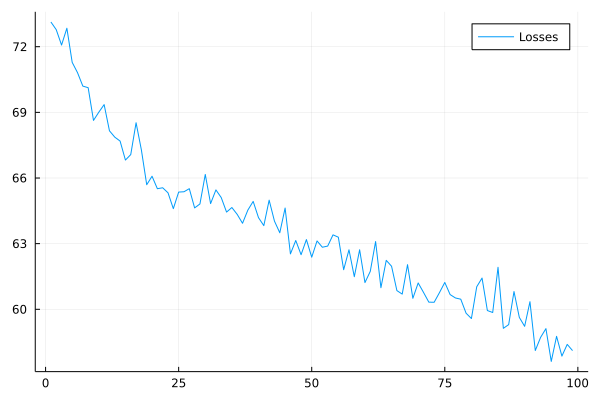

In [171]:
plot(vcat(losses[2:100]...), label="Losses")

In [172]:
#erst einmal so lassen, vielleicht einzelne Änderungen
function translate(x)
    ix = todevice(vocab(preprocess(x)))
    seq = [startsym]

    enc = encoder_forward(ix)

    len = length(ix)
    for i = 1:2len
        trg = todevice(vocab(seq))
        dec = decoder_forward(trg, enc)
        #move back to gpu due to argmax wrong result on CuArrays
        ntok = onecold(collect(dec), labels)
        push!(seq, ntok[end])
        ntok[end] == endsym && break
    end
  seq[2:end-1]
end

translate (generic function with 1 method)

In [173]:
translate(map(string, [5,5,6,6,1,12,3,4,6]))

10-element Vector{String}:
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"